## Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR,LinearSVR
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

## Get data 

In [2]:
#Get data from csv
data=pd.read_csv("municipality_bus_utilization.csv")

In [3]:
#Slice data wrt municipality
mun_4=data.loc[data["municipality_id"]==4]
mun_4["timestamp"] = pd.to_datetime(mun_4.timestamp)
mun_4["timestamp"] = pd.to_datetime(mun_4.timestamp.dt.strftime("%Y/%m/%d/%H"))

C:\Users\TOSHIBA\AppData\Local\Temp/ipykernel_9552/4227106013.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mun_4["timestamp"] = pd.to_datetime(mun_4.timestamp)
C:\Users\TOSHIBA\AppData\Local\Temp/ipykernel_9552/4227106013.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mun_4["timestamp"] = pd.to_datetime(mun_4.timestamp.dt.strftime("%Y/%m/%d/%H"))


## Prepare Data

In [4]:
#Max take
maxes_4=mun_4.groupby("timestamp")["usage"].max()

start_date="2017-06-04"

daily=pd.date_range(start_date,periods=10,freq="H")+pd.DateOffset(hours=7)
date = [pd.Series(daily + pd.DateOffset(days=i)) for i in range(77)]
date = pd.concat(date, ignore_index = True)
df = pd.DataFrame([], index = date)
df["usage"]=np.nan

#Assigning
df["usage"]=maxes_4
#Check Nan value number
df["usage"].isna().sum()
#check in advance 0 values 
df[df["usage"]==0].sum()

#fill NAs with 0
df.usage=df.usage.fillna(0)

## Missing data handling

In [5]:
#Make autoregressive missing values
for i in range(len(df)):
    if df.usage.iloc[i]==0:
        df.usage.iloc[i]=df.usage.iloc[i-10]

#Check missing value fills again they are not nan nor 0
df[df["usage"]==0].sum()
df[df["usage"]==np.nan].sum()

usage    0.0
dtype: float64

## Simple Baseline

In [6]:
#These simple ones may be changed according to prediction horizon
#Simple Baseline
#For one-week back (70 time-step)
df["preds_simple_baseline"]=df["usage"].shift(70)

## Prepare data for SVR

In [7]:
#Data preparation and normalization for SVR
m=df["usage"].iloc[:630].mean()
s=df["usage"].iloc[:630].std()
df["usage"]=(df["usage"]-m)/s       

lag=70
data_range=len(df)-4*lag+1
#Data preparation for the first week of the test
x=[]
y=[]
for i in range(data_range): #data_range=491
    x.append(df.usage.iloc[i:i+lag])
    y.append(df.usage.iloc[i+lag:i+2*lag])
X_train=np.array(x)
Y_train=np.array(y)

X_test1=df.usage.iloc[560:630].values.reshape(1,70)  #Inputs for the model for the first week
X_test2=df.usage.iloc[630:700].values.reshape(1,70)  #Inputs for the model for the second week


## ARIMA Deployment

In [8]:
#ARIMA
result=adfuller(df["usage"])
print(f"p value is: {result[1]}")

#No difference

p value is: 1.2634248095543808e-12


## Find lags for ARIMA

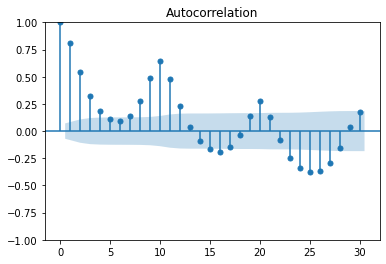

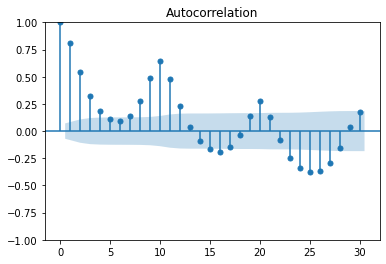

In [9]:
#ARIMA
#find AR values
plot_acf(df["usage"].values,lags=30)
#Then lag=10, no difference, MA=0 since the others no effect at all


## ARIMA model fit

In [10]:
#ARIMA
#p,d,q=10,0,0
#seasonal_order:70 for weekly cycle
X=df.usage.iloc[:630].values
mdl = ARIMA(X,order=(10,0,0), seasonal_order=(1,0,0,70)).fit()
ypred_1 = mdl.predict(X.size,X.size + 70 -1).reshape(70,1)

X_2=df.usage.iloc[:700].values
mdl_2=ARIMA(X_2,order=(10,0,0), seasonal_order=(1,0,0,70)).fit()
ypred_2 = mdl_2.predict(X.size,X.size + 70 -1).reshape(70,1)

arima_preds=np.concatenate([ypred_1,ypred_2])*s+m
MAE_arima=mean_absolute_error(arima_preds,(df.usage.iloc[630::]*s+m).values.reshape(140,1))
print("MAE arima:",MAE_arima)

#simple MAE
simple_MAE=mean_absolute_error((df.usage.iloc[630:770]*s+m).values.reshape(140,1),df.preds_simple_baseline.iloc[630:770].values.reshape(140,1))
print("Simple MAE:", simple_MAE)

MAE arima: 275.598265891431
Simple MAE: 271.1642857142857


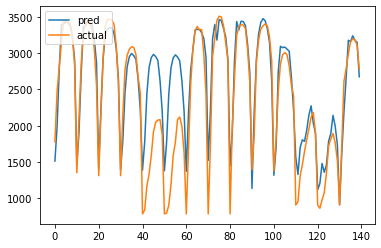

In [11]:
#ARIMA plots
plt.plot(arima_preds,label="pred")
plt.plot((df.usage.iloc[630:770]*s+m).values.reshape(140,1),label="actual")
plt.legend(loc="upper left")

## GBR Prediction

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
np.random.seed(3)
model=GBR()
mor=MultiOutputRegressor(model)
fitted=mor.fit(X_train,Y_train)
preds_1=(fitted.predict(X_test1).ravel()*s+m).reshape(70,1)
preds_2=(fitted.predict(X_test2).ravel()*s+m).reshape(70,1)

all_preds=np.concatenate([preds_1,preds_2])

MAE_GBR=mean_absolute_error(all_preds,(df.usage.iloc[630::]*s+m).values.reshape(140,1))
print("MAE_GBR is:", MAE_GBR)

#simple MAE
simple_MAE=mean_absolute_error((df.usage.iloc[630:770]*s+m).values.reshape(140,1),df.preds_simple_baseline.iloc[630:770].values.reshape(140,1))
print("Simple MAE:", simple_MAE)

In [ ]:
#GBR plots
plt.plot(all_preds,label="predicted_GBR")
plt.plot((df.usage.iloc[630:770]*s+m).values.reshape(140,1),label="actual")
plt.legend(loc="upper left")